In [1]:
from DP54 import DP54_solver
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from matplotlib.gridspec import GridSpec
import numba

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')  
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.fontsize'] = 13

In [3]:
t_range = np.array((0.0, 6.101))
h_size = np.array((1e-12 ,1e-1))
x0 = np.array((0, 0, 250.0))
argv = np.array([
    np.exp(24.6),  # k0
    8500.0,        # Ea_R
    - 560.0,        # deltaHr
    1.0,           # rho
    4.186,         # cP
    1e0,           # F 
    1.0,           # V 
    2,           # CA_in
    1,           # CB_in
    300.0          # T_in
])
reps = 1e-10
aeps = 1e-12
num_var = np.size(x0)
model = 4 # 1 is van der pol model
MAX_STEPS = int(904)
t_history, x_history, t_adaptive_size, t_adaptive = DP54_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)


Time: 0.000466 seconds
step size number is: 128


In [4]:
def cstr_1state(t, y, argv):
    # Extract state variables
    T = y
    
    # Extract parameters from argv array
    k0 = argv[0]      # Arrhenius constant
    Ea_R = argv[1]    # Activation energy / gas constant
    deltaHr = argv[2] # Reaction enthalpy
    rho = argv[3]     # Density
    cP = argv[4]      # Specific heat capacity
    F = argv[5]       # Flow rate
    V = argv[6]       # Reactor volume
    CA_in = argv[7]   # Inlet concentration of A
    CB_in = argv[8]   # Inlet concentration of B
    T_in = argv[9]    # Inlet temperature
    
    # Compute reaction rate
    k = k0 * np.exp(-Ea_R / T)  # Rate constant
    r = k * CA_in * CB_in             # Reaction rate
    
    # Temperature effect parameter
    beta = -deltaHr / (rho * cP)
    
    # Compute derivatives
    #dCA_dt = (CA_in - CA) * (F / V) - r
    #dCB_dt = (CB_in - CB) * (F / V) - 2.0 * r
    dT_dt = (T_in - T) * (F / V) + beta * r
    
    return [dT_dt]


In [5]:
start = time.perf_counter()
result = solve_ivp(
    lambda t, y: cstr_1state(t, y, argv),
    t_span = t_range,
    y0 = x0[2:3],
    method='RK45',
    rtol=reps,          
    atol=aeps, 
    #t_eval=np.linspace(0, 100, 1000),
    first_step=h_size[0],  
    max_step=h_size[1],   
)
t_history_scipy = result.t           
x_history_1_scipy = result.y[0, :]   
#x_history_2_scipy = result.y[1, :]  
#x_history_3_scipy = result.y[2, :]  
step_sizes = np.diff(result.t)

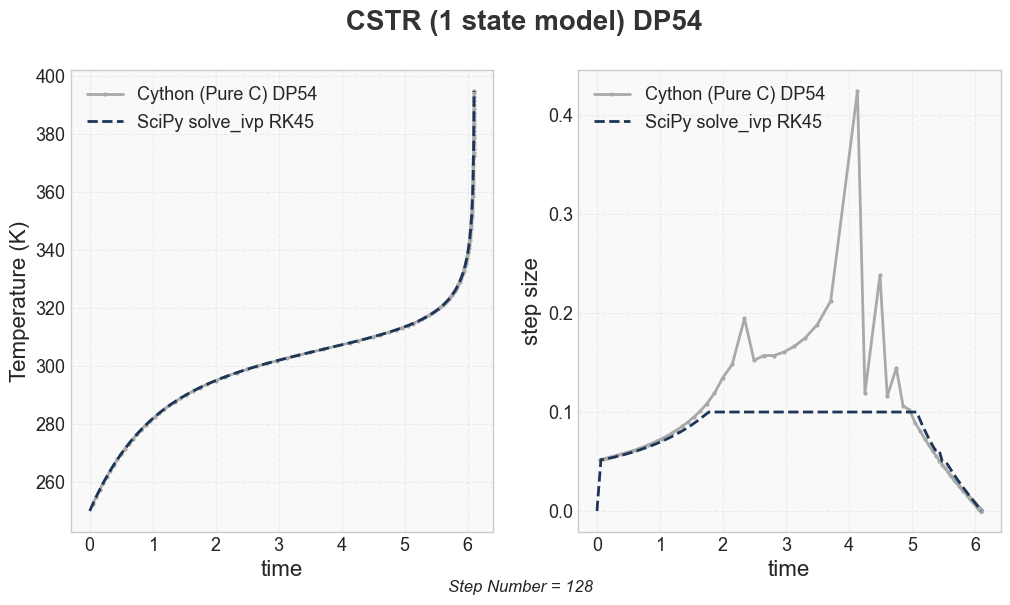

In [6]:
#x_history_1 = x_history[:, 0]
#x_history_2 = x_history[:, 1]
x_history_3 = x_history[:, 2]
fig = plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') 
gs = GridSpec(1, 2, figure=fig)
pic1 = fig.add_subplot(gs[0, 0])
pic2 = fig.add_subplot(gs[0, 1])
pic1.plot(t_history, x_history_3, '#A9A9A9', linewidth=2, markersize=4, marker='.', alpha=1, label=f'Cython (Pure C) DP54')    
pic1.plot(t_history_scipy, x_history_1_scipy, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--', label=f'SciPy solve_ivp RK45')    
pic2.plot(t_adaptive, t_adaptive_size, '#A9A9A9', linewidth=2, marker='.', markersize=4, alpha=1, label=f'Cython (Pure C) DP54')  
pic2.plot(t_history_scipy[1:], step_sizes, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--', label=f'SciPy solve_ivp RK45')    
#pic4.set_yscale('log')  
pic1.set_ylabel('Temperature (K)')
pic2.set_ylabel('step size')
pic2.grid(True, which="both", ls="--", alpha=0.3)
pic1.grid(True, which="both", ls="--", alpha=0.3)
pic1.legend() 
pic2.legend() 
pic1.set_facecolor('#f9f9f9')
pic2.set_facecolor('#f9f9f9')
pic1.set_xlabel('time')
pic2.set_xlabel('time')

#fig.suptitle('Prey-Predator Model ', fontsize=18, fontweight='bold')
fig.suptitle(' CSTR (1 state model) DP54', fontsize=20, fontweight='bold', color='#333333', y=0.98)
fig.text(0.5, 0.01, f'Step Number = {t_history.shape[0]}', ha='center', fontsize=12, style='italic')
plt.savefig("DP54_CSTR1.png")